In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from dask.dataframe.utils import make_meta
import matplotlib.pyplot as plt 
import numpy as np  
import lsdb
import pandas as pd
from catalog_filtering import bandFilterLenient, contains_PM

In [2]:
bandList = ['G','R','I','Z','Y']
class_star = 0.95
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
crucialCols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
catalog = lsdb.read_hipscat('hipscat/des_one_deg/', columns=crucialCols)
min_stars = 4
collinear_error = 0.2


In [3]:
filtered_catalog = catalog.query(query_string)
xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=18, suffixes=['_1', '_2'])
xmatch_ddf = xmatch._ddf

/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [4]:
neighbors = xmatch_ddf.groupby('_hipscat_index')['_dist_arcsec'].count()
neighbors -= 1 #Double counting adjustment
neighbors.name = 'neighbors'
xmatch_ddf = xmatch_ddf.join(neighbors, on='_hipscat_index')
#may need .assign if .join shuffles, shuffling is computationally expensive
xmatch_large_groups = xmatch_ddf.query('neighbors >= 3')


In [5]:
def distance_to_line(line_vector, PQ):
    return np.abs(np.cross(PQ, line_vector)) / np.linalg.norm(line_vector)

def within_collinear_error(line_vector, PQ, error):
    return (distance_to_line(line_vector, PQ) <= error)

columns_to_keep = (
        [col for col in xmatch_large_groups.columns if col.endswith('_1')]
    )

print(columns_to_keep)

['CLASS_STAR_G_1', 'CLASS_STAR_R_1', 'CLASS_STAR_I_1', 'CLASS_STAR_Z_1', 'CLASS_STAR_Y_1', 'FLAGS_G_1', 'FLAGS_R_1', 'FLAGS_I_1', 'FLAGS_Z_1', 'FLAGS_Y_1', 'RA_1', 'DEC_1', 'COADD_OBJECT_ID_1', 'SPREAD_MODEL_G_1', 'SPREAD_MODEL_R_1', 'SPREAD_MODEL_I_1', 'SPREAD_MODEL_Z_1', 'SPREAD_MODEL_Y_1', 'WAVG_MAG_PSF_G_1', 'WAVG_MAG_PSF_R_1', 'WAVG_MAG_PSF_I_1', 'WAVG_MAG_PSF_Z_1', 'WAVG_MAG_PSF_Y_1', 'WAVG_MAGERR_PSF_G_1', 'WAVG_MAGERR_PSF_R_1', 'WAVG_MAGERR_PSF_I_1', 'WAVG_MAGERR_PSF_Z_1', 'WAVG_MAGERR_PSF_Y_1']


# Maximum Error in Projection Distance

In [6]:
def max_proj_error(group):
    origin_ra, origin_dec = group['RA_1'], group['DEC_1']
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    
    
    x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
    y_vals = (dec2 - origin_dec) * 3600
    delta_coords = np.vstack((x_vals, y_vals)).T

    for i in range(len(delta_coords)):
        max_distance = 0
        proj_vector = delta_coords[i]
        if (not np.all(proj_vector)): continue #checks if array = [0 0]

        for k in range(len(delta_coords)):
            test_x, test_y = delta_coords[k]
            if ((test_x == 0) and (test_y == 0)) or (k == i): continue

            curr_distance = distance_to_line(proj_vector, np.array([test_x, test_y]))
            if (curr_distance > max_distance):
                max_distance = curr_distance
    group['max_proj_distance'] = max_distance
    return group[columns_to_keep + ['max_proj_distance']]


In [7]:
meta = make_meta(xmatch_large_groups[columns_to_keep])
meta['max_proj_distance'] = 0.0
star_groups = xmatch_large_groups.groupby('_hipscat_index').apply(max_proj_error, meta=meta)

In [9]:
with Client():
    df_1 = star_groups.compute()

df_1 = df_1.reset_index(drop=True, level=0)
df_1 = df_1.drop_duplicates()
df_1

,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,FLAGS_Y_1,...,WAVG_MAG_PSF_R_1,WAVG_MAG_PSF_I_1,WAVG_MAG_PSF_Z_1,WAVG_MAG_PSF_Y_1,WAVG_MAGERR_PSF_G_1,WAVG_MAGERR_PSF_R_1,WAVG_MAGERR_PSF_I_1,WAVG_MAGERR_PSF_Z_1,WAVG_MAGERR_PSF_Y_1,max_proj_distance
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10369096213407465472,0.979719,0.983354,0.985029,0.983997,0.972619,3,3,3,3,3,...,18.999428,18.179893,17.812717,17.724461,0.003647,0.001376,0.001141,0.001096,0.003837,9.959932
10369096215483645952,0.424446,0.24536,0.980153,0.83084,0.756592,3,3,3,3,3,...,23.590239,21.964289,21.144239,20.917528,-99.0,0.065354,0.021689,0.01724,0.065455,7.226110
10369096217102647296,0.493835,0.979279,0.983372,0.971719,0.932593,2,2,2,2,2,...,21.433695,20.187464,19.639479,19.498238,0.02911,0.008052,0.004712,0.004436,0.015799,6.432375
10369096221993205760,0.540009,0.980739,0.982748,0.932184,0.828752,0,0,0,0,0,...,21.916922,21.300776,20.996046,20.899529,0.046124,0.013064,0.011917,0.015186,0.065788,11.428107
10369099074845540352,0.343453,0.907556,0.983565,0.989397,0.976505,2,2,2,2,2,...,21.821548,19.601048,18.575277,18.294159,0.053532,0.01193,0.003003,0.002022,0.00614,11.121441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10374192528239886336,0.966997,0.983858,0.985583,0.980288,0.940612,2,2,2,2,2,...,21.222857,19.944988,19.387199,19.27405,0.02414,0.008273,0.004059,0.004057,0.01538,2.005406
10374192551841234944,0.909743,0.946556,0.978222,0.127373,0.019941,2,2,2,2,2,...,21.240795,21.006863,20.982113,20.893478,0.010423,0.008106,0.009712,0.014491,0.066777,2.164921
10374223768804392960,0.415803,0.357047,0.388831,0.952667,0.407131,0,0,0,0,0,...,-99.0,-99.0,20.244183,-99.0,-99.0,-99.0,-99.0,0.019065,-99.0,10.221021


Text(0.5, 1.0, 'Maximum Distance From Line Projection in Each Star Group')

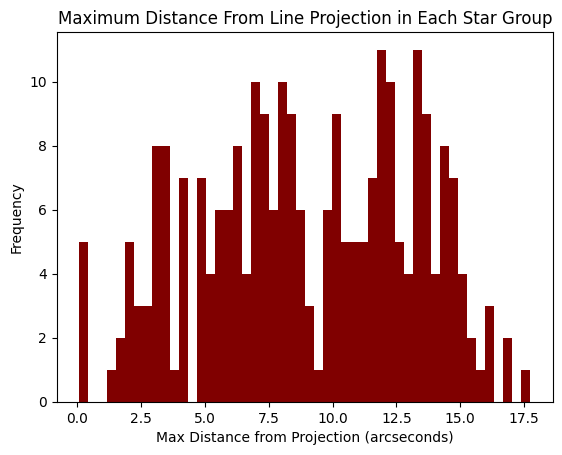

In [10]:
plt.hist(df_1['max_proj_distance'], bins = 50, color='maroon')
plt.xlabel('Max Distance from Projection (arcseconds)')
plt.ylabel('Frequency')
plt.title('Maximum Distance From Line Projection in Each Star Group')

# Is Collinear to Within Some Margin of Error

In [14]:
def is_collinear(group, error, min_stars):
    origin_ra, origin_dec = group['RA_1'], group['DEC_1']
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    is_collinear = False
    
    
    x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
    y_vals = (dec2 - origin_dec) * 3600
    delta_coords = np.vstack((x_vals, y_vals)).T

    for i in range(len(delta_coords)):
        proj_vector = delta_coords[i]
        found = 2

        if (not np.all(proj_vector)): continue #checks if array = [0 0]

        for k in range(len(delta_coords)):
            test_x, test_y = delta_coords[k]
            if ((test_x == 0) and (test_y == 0)) or (k == i): continue

            if within_collinear_error(proj_vector, np.array([test_x, test_y]), error):
                found += 1
        if (found >= min_stars):
            is_collinear = True
    
    group['is_collinear'] = is_collinear

    return group[columns_to_keep + ['is_collinear']]


In [ ]:
def max_proj_error(group):
    origin_ra, origin_dec = group['RA_1'], group['DEC_1']
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    
    
    x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
    y_vals = (dec2 - origin_dec) * 3600
    delta_coords = np.vstack((x_vals, y_vals)).T

    for i in range(len(delta_coords)):
        max_distance = 0
        proj_vector = delta_coords[i]
        if (not np.all(proj_vector)): continue #checks if array = [0 0]

        for k in range(len(delta_coords)):
            test_x, test_y = delta_coords[k]
            if ((test_x == 0) and (test_y == 0)) or (k == i): continue

            curr_distance = distance_to_line(proj_vector, np.array([test_x, test_y]))
            if (curr_distance > max_distance):
                max_distance = curr_distance
    group['max_proj_distance'] = max_distance
    return group[columns_to_keep + ['max_proj_distance']]

In [15]:
meta = make_meta(xmatch_large_groups[columns_to_keep])
meta['is_collinear'] = 0.0
star_groups = xmatch_large_groups.groupby('_hipscat_index').apply(is_collinear, meta=meta, error=collinear_error, min_stars=min_stars)

In [16]:
with Client():
    df_2 = star_groups.compute()

df_2 = df_2.reset_index(drop=True, level = 0)
df_2 = df_2.drop_duplicates()
df_2

,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,FLAGS_Y_1,...,WAVG_MAG_PSF_R_1,WAVG_MAG_PSF_I_1,WAVG_MAG_PSF_Z_1,WAVG_MAG_PSF_Y_1,WAVG_MAGERR_PSF_G_1,WAVG_MAGERR_PSF_R_1,WAVG_MAGERR_PSF_I_1,WAVG_MAGERR_PSF_Z_1,WAVG_MAGERR_PSF_Y_1,is_collinear
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10369096213407465472,0.979719,0.983354,0.985029,0.983997,0.972619,3,3,3,3,3,...,18.999428,18.179893,17.812717,17.724461,0.003647,0.001376,0.001141,0.001096,0.003837,False
10369096215483645952,0.424446,0.24536,0.980153,0.83084,0.756592,3,3,3,3,3,...,23.590239,21.964289,21.144239,20.917528,-99.0,0.065354,0.021689,0.01724,0.065455,False
10369096217102647296,0.493835,0.979279,0.983372,0.971719,0.932593,2,2,2,2,2,...,21.433695,20.187464,19.639479,19.498238,0.02911,0.008052,0.004712,0.004436,0.015799,False
10369096221993205760,0.540009,0.980739,0.982748,0.932184,0.828752,0,0,0,0,0,...,21.916922,21.300776,20.996046,20.899529,0.046124,0.013064,0.011917,0.015186,0.065788,False
10369099074845540352,0.343453,0.907556,0.983565,0.989397,0.976505,2,2,2,2,2,...,21.821548,19.601048,18.575277,18.294159,0.053532,0.01193,0.003003,0.002022,0.00614,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10374192528239886336,0.966997,0.983858,0.985583,0.980288,0.940612,2,2,2,2,2,...,21.222857,19.944988,19.387199,19.27405,0.02414,0.008273,0.004059,0.004057,0.01538,False
10374192551841234944,0.909743,0.946556,0.978222,0.127373,0.019941,2,2,2,2,2,...,21.240795,21.006863,20.982113,20.893478,0.010423,0.008106,0.009712,0.014491,0.066777,False
10374223768804392960,0.415803,0.357047,0.388831,0.952667,0.407131,0,0,0,0,0,...,-99.0,-99.0,20.244183,-99.0,-99.0,-99.0,-99.0,0.019065,-99.0,False


In [17]:
filtered_df_2 = df_2.query('is_collinear == True')
filtered_df_2



,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,FLAGS_Y_1,...,WAVG_MAG_PSF_R_1,WAVG_MAG_PSF_I_1,WAVG_MAG_PSF_Z_1,WAVG_MAG_PSF_Y_1,WAVG_MAGERR_PSF_G_1,WAVG_MAGERR_PSF_R_1,WAVG_MAGERR_PSF_I_1,WAVG_MAGERR_PSF_Z_1,WAVG_MAGERR_PSF_Y_1,is_collinear
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10370986798804369408,0.005172,0.982307,0.9952,0.994617,0.99233,3,3,3,3,3,...,19.362398,17.116657,15.483732,14.955669,0.05949,0.003771,0.001143,0.0008,0.001202,True
10370986798997307392,0.363681,0.980886,0.990194,0.132001,0.976497,3,3,3,3,3,...,19.425049,17.086205,-99.0,14.967874,0.044888,0.004398,0.001177,-99.0,0.001725,True
10370986891217469440,0.478828,0.895304,0.977812,0.984843,0.983378,3,3,3,3,3,...,-99.0,-99.0,15.489192,-99.0,-99.0,-99.0,-99.0,0.001013,-99.0,True
10370986892068913152,0.19909,0.980313,0.985622,0.028624,0.98472,3,3,3,3,3,...,19.385511,17.113192,-99.0,14.974467,0.044052,0.004155,0.000972,-99.0,0.000905,True


Text(0.5, 1.0, 'Possible PM Stars Following Star Filtering and Line Projection (DASK)')

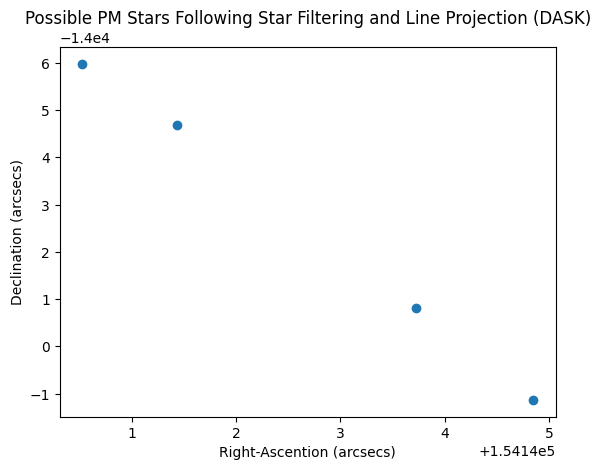

In [18]:
plt.scatter(filtered_df_2['RA_1'] * 3600, filtered_df_2['DEC_1'] * 3600)
plt.xlabel('Right-Ascention (arcsecs)')
plt.ylabel('Declination (arcsecs)')
plt.title('Possible PM Stars Following Star Filtering and Line Projection (DASK)')

In [27]:
def second__min_proj_error(group, aligned_count):
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    coords = np.vstack((ra2, dec2)).T

    min_distance = -1
    second_min_distance = -1

    for i in range(len(coords)):
        origin_ra, origin_dec = coords[i]
        x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
        y_vals = (dec2 - origin_dec) * 3600
        delta_coords = np.vstack((x_vals, y_vals)).T

        for j in range(i + 1, len(delta_coords)):
            proj_vector = delta_coords[j]

            for k in range(len(delta_coords)):
                if k == j or k == i:
                    continue

                test_x, test_y = delta_coords[k]
                curr_distance = projection_distance(proj_vector, test_x, test_y)
                if (curr_distance < min_distance) or (min_distance < 0):
                    min_distance, second_min_distance = curr_distance, min_distance
                elif (curr_distance < second_min_distance) or (second_min_distance < 0):
                    second_min_distance = curr_distance
    group['second_min_proj_error'] = second_min_distance
    group['group_id'] = group_id
    return group[columns_to_keep + ['second_min_proj_error', 'group_id']]



In [28]:
meta = make_meta(xmatch_large_groups[columns_to_keep])
meta['second_min_proj_error'] = 0.0
meta['group_id'] = 0.0
star_groups = xmatch_large_groups.groupby('_hipscat_index').apply(add_group_id, meta=meta)

In [31]:
with Client():
    df_3 = star_groups.compute()

In [32]:
df_3.reset_index(drop=True,inplace=True)
#for some reason this is not working
df_3.drop_duplicates(inplace=True)

df_3

,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,FLAGS_Y_1,...,WAVG_MAG_PSF_I_1,WAVG_MAG_PSF_Z_1,WAVG_MAG_PSF_Y_1,WAVG_MAGERR_PSF_G_1,WAVG_MAGERR_PSF_R_1,WAVG_MAGERR_PSF_I_1,WAVG_MAGERR_PSF_Z_1,WAVG_MAGERR_PSF_Y_1,second_min_proj_error,group_id
0,0.979719,0.983354,0.985029,0.983997,0.972619,3,3,3,3,3,...,18.179893,17.812717,17.724461,0.003647,0.001376,0.001141,0.001096,0.003837,3.335621,951527771
4,0.424446,0.24536,0.980153,0.83084,0.756592,3,3,3,3,3,...,21.964289,21.144239,20.917528,-99.0,0.065354,0.021689,0.01724,0.065455,3.335621,951527771
8,0.493835,0.979279,0.983372,0.971719,0.932593,2,2,2,2,2,...,20.187464,19.639479,19.498238,0.02911,0.008052,0.004712,0.004436,0.015799,1.153103,742377214
13,0.540009,0.980739,0.982748,0.932184,0.828752,0,0,0,0,0,...,21.300776,20.996046,20.899529,0.046124,0.013064,0.011917,0.015186,0.065788,3.335622,951527771
17,0.343453,0.907556,0.983565,0.989397,0.976505,2,2,2,2,2,...,19.601048,18.575277,18.294159,0.053532,0.01193,0.003003,0.002022,0.00614,6.026917,610180362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.966997,0.983858,0.985583,0.980288,0.940612,2,2,2,2,2,...,19.944988,19.387199,19.27405,0.02414,0.008273,0.004059,0.004057,0.01538,0.604100,972455823
1024,0.909743,0.946556,0.978222,0.127373,0.019941,2,2,2,2,2,...,21.006863,20.982113,20.893478,0.010423,0.008106,0.009712,0.014491,0.066777,0.992385,460204246
1028,0.415803,0.357047,0.388831,0.952667,0.407131,0,0,0,0,0,...,-99.0,20.244183,-99.0,-99.0,-99.0,-99.0,0.019065,-99.0,4.774385,112867428
1032,0.978269,0.592493,0.855997,0.185873,0.154502,2,2,2,2,2,...,22.867495,22.63636,21.836956,0.033761,0.036479,0.053451,0.070757,0.282235,4.774385,112867428


Text(0.5, 0, 'Second Minimum Distance (arcseconds)')

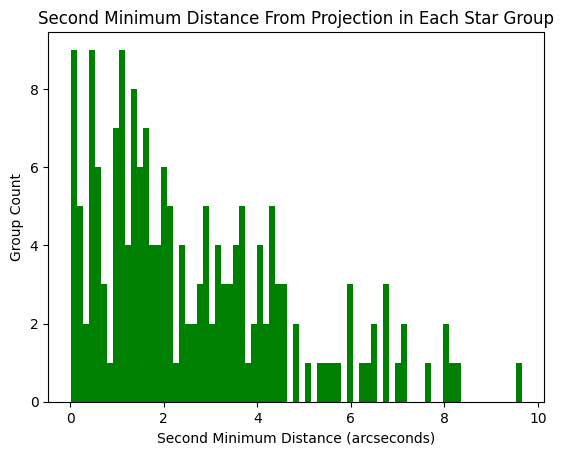

In [40]:
plt.hist(df_3.drop_duplicates(subset=['group_id'])['second_min_proj_error'], bins=75, color = 'green')
plt.title('Second Minimum Distance From Projection in Each Star Group')
plt.ylabel('Group Count')
plt.xlabel('Second Minimum Distance (arcseconds)')


In [ ]:
df_3.query('second_min_proj_error ')